# Pressure: An Observational Study 😨

Hypothesis: Higher pressure situations lessen the likelihood of field goal conversion.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

## Load & Clean

In [2]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
2166,AD-0800,1,38,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.764708,765
2185,AD-0800,1,27,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.807721,766
4565,AD-0800,1,36,2000,17,80,TEN,Adelphia Coliseum,TEN,0,...,1,13,0,0,1,0,0,5,NaN,767
8564,AD-0800,1,24,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.842837,768
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,ZG-0050,1,30,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,0,0,0,0,0,0,1,0.826709,62
865338,ZG-0050,1,21,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,11,0,0,0,0,0,2,0.858217,63
868268,ZG-0050,1,22,2019,3,43,SEA,CenturyLink Field,ARI,0,...,1,7,1,0,0,1,0,1,1.000000,64


In [3]:
df.describe()

,good,dist,year,seasons,temperature,XP,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
count,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.0,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18710.000000,18803.000000
mean,0.844865,36.881242,2009.516992,7.913099,60.776153,0.0,29.927139,0.033771,0.352178,6.549593,0.487901,0.040845,0.125033,0.445408,0.080413,1.400202,0.844876,255.230601
std,0.362043,10.070235,5.643918,5.162924,15.706069,0.0,5.250091,0.180645,0.477662,5.986469,0.499867,0.197935,0.330765,0.497024,0.271938,1.024004,0.124109,209.053136
min,0.000000,18.000000,2000.000000,1.000000,-6.000000,0.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,28.000000,2005.000000,4.000000,51.000000,0.0,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.772214,94.000000
50%,1.000000,37.000000,2010.000000,7.000000,64.000000,0.0,29.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.865337,201.000000
75%,1.000000,45.000000,2014.000000,11.000000,70.000000,0.0,33.000000,0.000000,1.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.945632,362.000000
max,1.000000,76.000000,2019.000000,26.000000,109.000000,0.0,47.000000,1.000000,1.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1033.000000


## Explore

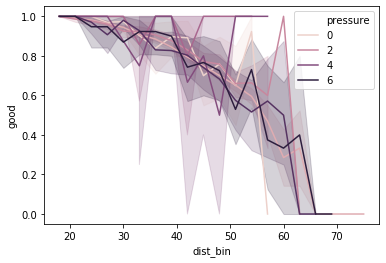

In [4]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='pressure', data=df_)

In [5]:
df = df[(df['dist']>=40)]
df.dropna(inplace=True)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
8652,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,2,0.894946,770
11064,AD-0800,0,46,2000,17,72,TEN,Adelphia Coliseum,TEN,0,...,1,5,0,0,1,0,0,1,1.000000,771
12417,AD-0800,1,41,2000,17,44,CIN,Paul Brown Stadium,TEN,0,...,1,10,1,0,0,0,0,1,0.842957,773
16254,AD-0800,0,44,2000,17,74,TEN,Adelphia Coliseum,TEN,0,...,0,6,0,0,0,0,0,1,0.671096,777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844674,ZG-0050,1,47,2019,3,56,NYG,MetLife Stadium,ARI,0,...,1,3,1,0,0,1,1,1,0.813096,52
846996,ZG-0050,1,50,2019,3,70,NO,Mercedes-Benz Superdome,ARI,0,...,0,0,1,0,0,1,0,1,0.771461,56
851666,ZG-0050,1,54,2019,3,77,TB,Raymond James Stadium,ARI,0,...,0,8,1,0,0,0,0,1,0.883073,59


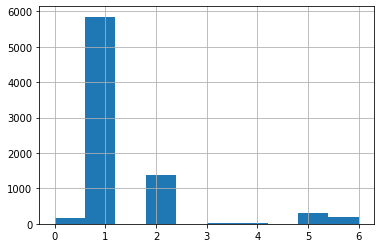

In [8]:
df['pressure'].hist()

In [7]:
df['pressure'].value_counts()

1    5846
2    1377
5     295
6     201
0     160
3      15
4      15
Name: pressure, dtype: int64

The distribution is very skewed. It may be necessary to collapse some of the categories. \[0,1\],\[2,3,4\],\[5,6\] (i.e. low, medium, high pressure)

In [9]:
df['pressure'] = df['pressure'].map({0:0, 1:0, 2:1, 3:1, 4:1, 5:2, 6:2})

In [58]:
df_low = df[df['pressure']==0]
df_med = df[df['pressure']==1]
df_high = df[df['pressure']==2]

In [59]:
df['pressure'].value_counts()

0    6006
1    1407
2     496
Name: pressure, dtype: int64

## Pair

In [60]:
def get_mask(data, row, pressure, ddist=4, dwind=7, dtemp=10, dyear=1, dkicks=100, dseas=2, dage=2):
    mask = (data['iced']==row['iced']) &\
           (abs(data['kicks']-row['kicks'])<=dkicks) &\
           (abs(data['seasons']-row['seasons'])<=dseas) &\
           (abs(data['age']-row['age'])<=dseas) &\
           (abs(data['dist']-row['dist'])<=ddist) &\
           (abs(data['wind']-row['wind'])<=dwind) &\
           (abs(data['temperature']-row['temperature'])<=dtemp) &\
           (abs(data['year']-row['year'])<=dyear) &\
           (data['postseason']==row['postseason']) &\
           (data['turf']==row['turf']) &\
           (data['altitude']==row['altitude']) &\
           (data['away_game']==row['away_game']) &\
           (data['precipitation']==row['precipitation']) &\
           (data['pressure']==pressure) # want rows at this level
    return mask

def get_diff(df, row):
    for i in row.index:
        if not isinstance(row[i],str):
            df[i+'_d'] = df[i].sub(row[i]).abs()
    return df

In [61]:
pressures = {}
for level, df_pres in zip((0,1),(df_low,df_med)):
    pres = {}
    for index, row in df_high.iterrows():
        mask = get_mask(df_pres, row, level)
        df_choices = get_diff(df_pres[mask],row).sort_values(['dist_d','year_d','kicks_d','wind_d','temperature_d','seasons_d','age_d'])
        for i, choice in df_choices.iterrows():
            if i not in pres:
                choice['match_pid'] = index
                pres[i] = choice
                break
    print(len(df_high)-len(pres), 'are missing matches.')
    pressures[level] = pd.DataFrame.from_dict(pres, orient='index').sort_values(['dist_d','year_d','seasons_d'])

236 are missing matches.
345 are missing matches.


In [62]:
low_matches = set(pressures[0]['match_pid'])
med_matches = set(pressures[1]['match_pid'])
both_matched = low_matches.intersection(med_matches)
print(len(both_matched), 'crossover.')
df_high = df_high.loc[both_matched,:]
df_low = pressures[0][pressures[0]['match_pid'].isin(both_matched)]
df_med = pressures[1][pressures[1]['match_pid'].isin(both_matched)]
df_high

119 crossover.


,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
276481,JE-0200,1,49,2006,14,70,DEN,Invesco Field at Mile High,DEN,0,...,0,4,0,0,0,0,0,2,0.928651,567
109570,SC-0700,1,40,2002,13,72,SD,Qualcomm Stadium,SD\r,0,...,0,9,0,0,0,0,0,2,0.824461,545
162308,JK-0200,1,49,2003,13,63,ARI,Sun Devil Stadium,CAR,0,...,0,4,1,0,0,0,0,2,0.932399,514
871945,WL-0300,1,49,2019,4,70,NO,Mercedes-Benz Superdome,NO\r,0,...,0,0,0,1,1,1,0,2,0.797127,144
115213,JE-0200,0,53,2002,10,64,SD,Qualcomm Stadium,DEN,0,...,1,7,1,0,0,0,0,2,0.759732,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149999,JH-0900,1,48,2003,12,72,DET,Ford Field,DET,0,...,0,0,0,0,0,1,0,2,0.967310,502
682485,JB-7100,0,48,2015,13,51,NYG,MetLife Stadium,NYG,0,...,0,8,0,0,0,1,0,2,0.999624,371
618486,DB-0200,1,49,2014,4,70,DAL,AT&T Stadium,DAL,0,...,0,0,0,0,0,1,0,2,0.811407,107


## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free.

In [63]:
from scipy.stats import beta
p_hat = df[df['dist']>=40]['good'].mean()
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 5


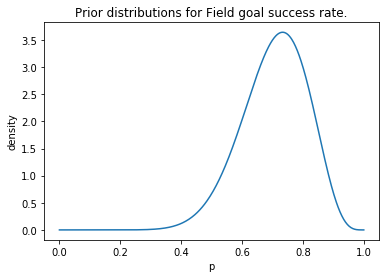

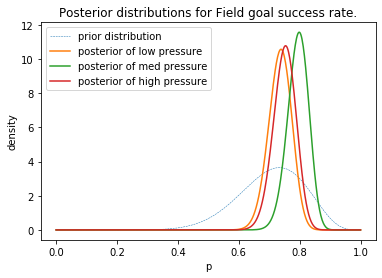

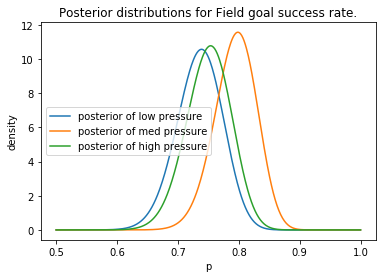

In [64]:
from util.bayes import BetaBinomial

# setup random variables
low = BetaBinomial(alpha_, beta_, 'low pressure')
medium = BetaBinomial(alpha_, beta_, 'med pressure')
high = BetaBinomial(alpha_, beta_, 'high pressure')
low.plot_prior(show=True)
plt.cla()

# update prior
low.observe(df_low['good'])
medium.observe(df_med['good'])
high.observe(df_high['good'])

# plot posterior
low.plot_posterior(prior=True)
medium.plot_posterior(prior=False)
high.plot_posterior(prior=False, show=True)

# zoom in
x = np.linspace(0.5,1,500)
low.plot_posterior(x, prior=False)
medium.plot_posterior(x, prior=False)
high.plot_posterior(x, prior=False, show=True)

# sample from posterior
samples = 20000
samples_posterior_low = low.sample(samples)
samples_posterior_med = medium.sample(samples)
samples_posterior_high = high.sample(samples)

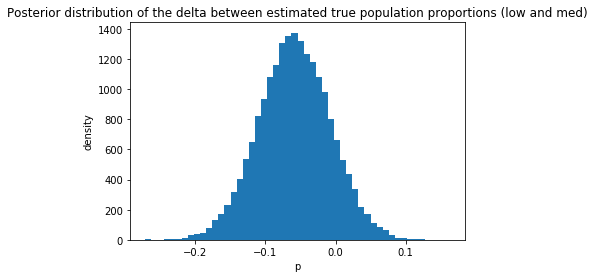

12 % likely that low pressure has a higher true population proportion of converted field goals than medium pressure.
-0.06 is the median difference, with a 50% credible interval of (0.0,-0.12).


In [65]:
posterior_diff = samples_posterior_low - samples_posterior_med

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and med)')
plt.show()
print(int((samples_posterior_low>samples_posterior_med).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than medium pressure.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

84 % likely relative lift of medium over low pressure kicks greater than 1%.
0.08 is the median relative lift, with a 50% credible interval of (0.0,0.16).


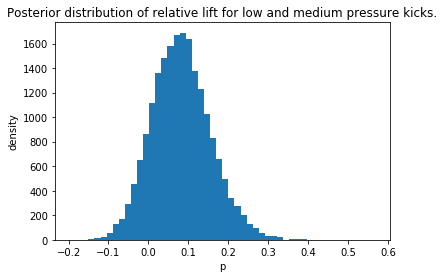

In [66]:
posterior_relative = (samples_posterior_med-samples_posterior_low)/samples_posterior_low
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and medium pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift of medium over low pressure kicks greater than 1%.')

center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

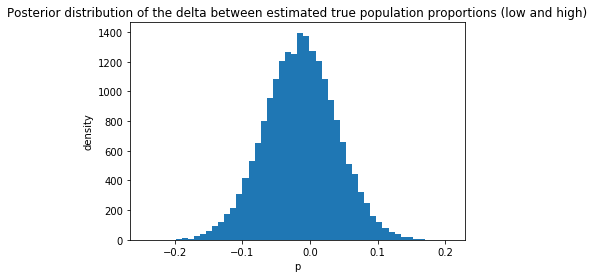

39 % likely that low pressure has a higher true population proportion of converted field goals than high pressure.
-0.01 is the median difference, with a 50% credible interval of (0.0,-0.03).


In [67]:
posterior_diff = samples_posterior_low - samples_posterior_high

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and high)')
plt.show()
print(int((samples_posterior_low>samples_posterior_high).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than high pressure.')

center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

54 % likely relative lift of high over low pressure kicks greater than 1%.
0.02 is the median relative lift, with a 50% credible interval of (0.0,0.04).


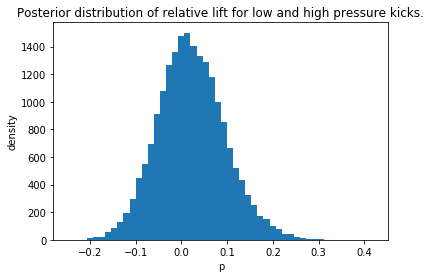

In [68]:
posterior_relative = (samples_posterior_high-samples_posterior_low)/samples_posterior_low
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and high pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift of high over low pressure kicks greater than 1%.')

center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

## Conclusions

* There is no noticeable difference in estimated true population proportion for high and low kicks.
* But medium pressure kicks seem to have the highest rate of conversion.
* This is contrary to popular belief that pressure has a negative effect on kickers.